```
Coursework Assignment: Building a Regression Model
University of London
BSc in Computer Science
CM3005, Data Science
Hudson Leonardo MENDES
hlm12@student.london.ac.uk
```


# I. Introduction


## Domain-specific area


## Dataset


## Objectives


# II. Implementation


## Preprocessing


In [1]:
import pathlib

data_folderpath = pathlib.Path("./data")

ppd_folderpath = data_folderpath / "uk-ppd"
inflation_filepath = data_folderpath / "uk-ons/ons-inflation-1989-2022.csv"
interest_filepath = data_folderpath / "uk-boe/boe-interest-1975-2022.csv"


In [2]:
import pandas as pd

pd.set_option("display.float_format", lambda x: "{:,.3f}".format(x))


In [3]:
# https://www.gov.uk/guidance/about-the-price-paid-data
ppd_property_type = {
    "D": "detached",
    "S": "semi-detached",
    "T": "terraced",
    "F": "flat/maisonettes",
    # "O": "other" # => intentionally ommitted
}

ppd_duration = {"F": "freehold", "L": "leasehold"}

ppd_old_or_new = {"Y": "new", "N": "old"}

ppd_df = pd.concat(
    [
        pd.read_csv(
            ppd_filepath,
            compression="zip",
            names=[
                "id",
                "price",
                "date",
                "postcode",
                "property_type",
                "old_or_new",
                "duration",
                "paon",
                "saon",
                "street",
                "locality",
                "town_city",
                "district",
                "county",
                "ppd_category_type",
                "record_status",
            ],
        )
        for ppd_filepath in ppd_folderpath.glob("*.zip")
    ]
)
ppd_df["postgroup"] = ppd_df["postcode"].map(lambda x: str(x).split(" ")[0])
ppd_df["date"] = pd.to_datetime(ppd_df["date"])
ppd_df["property_type"] = ppd_df["property_type"].map(ppd_property_type.get)
ppd_df["duration"] = ppd_df["duration"].map(ppd_duration.get)
ppd_df["old_or_new"] = ppd_df["old_or_new"].map(ppd_old_or_new.get)
ppd_df = ppd_df[
    [
        "date",
        "postgroup",
        "property_type",
        "old_or_new",
        "duration",
        "price",
    ]
]
ppd_df = ppd_df.astype(
    {
        "postgroup": "category",
        "property_type": "category",
        "old_or_new": "category",
        "duration": "category",
        "price": "double",
    }
)
ppd_df = ppd_df.dropna()
ppd_df.sample(n=5)


,date,postgroup,property_type,old_or_new,duration,price
376384,2022-03-24,N14,detached,old,freehold,"935,000.000"
813247,2020-08-21,LL22,detached,old,freehold,"205,000.000"
862553,2020-01-03,DH1,flat/maisonettes,old,leasehold,"63,000.000"
82423,2018-01-19,DY5,semi-detached,old,freehold,"163,000.000"
342029,2018-03-28,DE4,flat/maisonettes,new,leasehold,"309,000.000"


In [4]:
import re
import string
from datetime import date

inflation_date_pattern = re.compile(r"([\d]{4})(?:\s+([\w]{3}))?")
inflation_month_names = [
    "JAN",
    "FEB",
    "MAR",
    "APR",
    "MAY",
    "JUN",
    "JUL",
    "AUG",
    "SEP",
    "OCT",
    "NOV",
    "DEC",
]
inflation_month_index = {mn: ix + 1 for (ix, mn) in enumerate(inflation_month_names)}
inflation_month_index["Q1"] = 1
inflation_month_index["Q2"] = 4
inflation_month_index["Q3"] = 7
inflation_month_index["Q3"] = 10

inflation_acceptable_numeric_chars = string.digits + ".,"


def extract_inflation_date(x: str) -> date:
    match = next(inflation_date_pattern.finditer(x), None)
    if match:
        group_count = len(match.groups())
        if group_count >= 1:
            year = int(match.group(1))
            month = 1
            month_name = match.group(2)
            if group_count > 1 and month_name:
                month_name = month_name.strip().upper()
                month = inflation_month_index.get(month_name)
            return date(year, month, 1)


def extract_inflation_rate(x: str) -> float:
    x = str(x)
    if all([c in inflation_acceptable_numeric_chars for c in x]):
        return float(x)
    return None


inflation_df = pd.read_csv(inflation_filepath)
inflation_df["date"] = inflation_df["Title"].map(extract_inflation_date)
inflation_df["date"] = pd.to_datetime(inflation_df["date"])
inflation_df["rate"] = inflation_df["CPIH ANNUAL RATE 00: ALL ITEMS 2015=100"].map(
    extract_inflation_rate
)
inflation_df["rate"] = inflation_df["rate"].astype("float", errors="ignore")
inflation_df = inflation_df[["date", "rate"]]
inflation_df = inflation_df.dropna()
inflation_df = inflation_df.set_index("date").sort_index()
inflation_df.sample(n=5)


,rate
date,
2013-09-01,2.400
2022-01-01,5.500
2022-04-01,7.800
2004-01-01,1.300
1995-08-01,2.700


In [5]:
interest_df = pd.read_csv(interest_filepath)
interest_df["date"] = pd.to_datetime(interest_df["Date Changed"])
interest_df["rate"] = interest_df["Rate"].astype("float")
interest_df = interest_df[["date", "rate"]]
interest_df = interest_df.set_index("date").sort_index()
interest_df.sample(n=5)


,rate
date,
1979-11-15,17.000
1982-08-17,11.250
1981-11-06,15.060
1981-08-25,12.690
1989-09-08,13.750


In [6]:
from tqdm import tqdm, trange
from typing import Callable
from datetime import date, timedelta

tqdm.pandas()


def build_rate_extractor(df: pd.DataFrame) -> Callable[[date], float]:
    min_date = df.index.min()
    max_date = df.index.max()
    cur_date = min_date
    rate_index = {}
    first_rate = df.rate[0]
    prev_rate = first_rate
    last_rate = df.rate[-1]
    with trange((max_date - min_date).days, desc="rate_index") as pbar:
        while cur_date <= max_date:
            rates = df[df.index == cur_date].rate
            if rates.any():
                new_rate = rates[0] / 100.0
                rate_index[cur_date] = new_rate
                prev_rate = new_rate
            else:
                rate_index[cur_date] = prev_rate
            cur_date += timedelta(days=1)
            pbar.update()

    def get_rate_for_date(d: date) -> float:
        if d < min_date:
            return first_rate
        elif d > max_date:
            return last_rate
        else:
            return rate_index[d]

    return get_rate_for_date


df = ppd_df.copy()
df["inflation_rate"] = df.date.progress_map(build_rate_extractor(df=inflation_df))
df["interest_rate"] = df.date.progress_map(build_rate_extractor(df=interest_df))
df["date_year"] = df.date.progress_map(lambda d: d.year)
df["date_month"] = df.date.progress_map(lambda d: d.month)
df["date_day"] = df.date.progress_map(lambda d: d.day)
df["date_day_of_week"] = df.date.progress_map(lambda d: d.weekday())
df = df.sort_values(by="date").reset_index()
df = df[
    ["date_year", "date_month", "date_day", "date_day_of_week"]
    + list(ppd_df.columns[1:-1])
    + ["inflation_rate", "interest_rate", "price"]
]
df.sample(n=5)


rate_index: 12358it [00:06, 1893.80it/s]                           
100%|██████████| 4336841/4336841 [00:19<00:00, 226386.02it/s]
rate_index: 17497it [00:09, 1788.41it/s]                           
100%|██████████| 4336841/4336841 [00:14<00:00, 305791.14it/s]


,date_year,date_month,date_day,date_day_of_week,postgroup,property_type,old_or_new,duration,inflation_rate,interest_rate,price
3701511,2021,11,10,2,DA8,terraced,old,freehold,0.046,0.001,"357,500.000"
2235724,2020,7,3,4,PE38,detached,old,freehold,0.011,0.001,"360,000.000"
1498335,2019,8,7,2,CV22,flat/maisonettes,old,leasehold,0.017,0.007,"107,000.000"
127954,2018,2,28,2,CO15,detached,old,freehold,0.025,0.005,"308,750.000"
473277,2018,7,13,4,DN37,terraced,old,freehold,0.023,0.005,"85,000.000"


## Statistical Summary


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4336841 entries, 0 to 4336840
Data columns (total 11 columns):
 #   Column            Dtype   
---  ------            -----   
 0   date_year         int64   
 1   date_month        int64   
 2   date_day          int64   
 3   date_day_of_week  int64   
 4   postgroup         category
 5   property_type     category
 6   old_or_new        category
 7   duration          category
 8   inflation_rate    float64 
 9   interest_rate     float64 
 10  price             float64 
dtypes: category(4), float64(3), int64(4)
memory usage: 252.4 MB


In [8]:
df.describe()


,date_year,date_month,date_day,date_day_of_week,inflation_rate,interest_rate,price
count,"4,336,841.000","4,336,841.000","4,336,841.000","4,336,841.000","4,336,841.000","4,336,841.000","4,336,841.000"
mean,"2,019.828",6.481,17.235,2.717,0.025,0.005,"318,106.045"
std,1.343,3.392,8.971,1.463,0.020,0.004,"399,667.085"
min,"2,018.000",1.000,1.000,0.000,0.005,0.001,1.000
25%,"2,019.000",3.000,10.000,2.000,0.015,0.001,"160,000.000"
50%,"2,020.000",6.000,18.000,3.000,0.020,0.005,"247,000.000"
75%,"2,021.000",9.000,25.000,4.000,0.024,0.007,"376,999.000"
max,"2,022.000",12.000,31.000,6.000,0.096,0.022,"165,000,000.000"


## Data visualisation


In [9]:
%matplotlib inline

In [10]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter


In [11]:
from datetime import date

max_price = float(df.price.max())
max_rate = max(df.interest_rate.max(), df.inflation_rate.max())
min_intersecting_date = date(df.date_year.min(), 1, 1)
max_intersecting_date = date(df.date_year.max(), 12, 30)


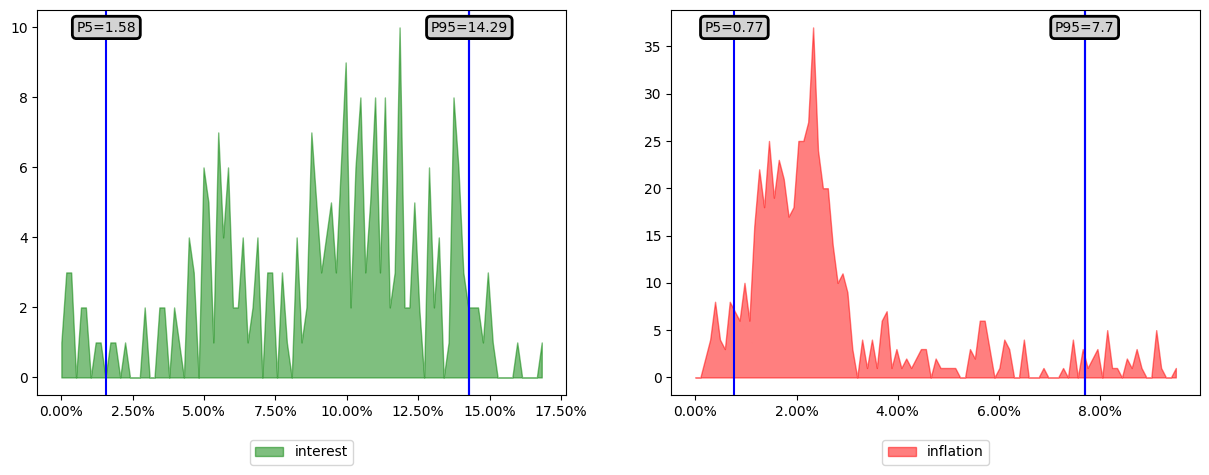

In [12]:
_, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))


def plot_rate_distributions(ax, df: pd.DataFrame, label: str, color: str):
    df = df.copy()
    x = np.linspace(0.0, df["rate"].max(), 100)
    df["bin"] = pd.cut(df["rate"], bins=x)
    y = list(df.groupby("bin").count()["rate"])
    ax.fill_between(x[:-1], 0.0, y, color=color, alpha=0.5)
    ax.xaxis.set_major_formatter(FormatStrFormatter("%2.2f%%"))
    intervals = [0.05, 0.95]
    for interval, quantile in zip(intervals, df.rate.quantile(intervals)):
        percentile = f"P{int(interval*100.)}={round(quantile, 2)}"
        bbox = dict(boxstyle="round, pad=0.3", fc="lightgray", lw=2)
        ax.axvline(x=quantile, color="blue")
        ax.annotate(
            percentile,
            xy=(quantile, max(y)),
            bbox=bbox,
            ha="center",
            va="center",
        )
    ax.axvline(x=quantile, color="blue")
    ax.legend([label], loc="lower center", bbox_to_anchor=(0.5, -0.2))


plot_rate_distributions(
    ax=axes[0],
    df=interest_df,
    label="interest",
    color="green",
)

plot_rate_distributions(
    ax=axes[1],
    df=inflation_df,
    label="inflation",
    color="red",
)


In [13]:
from datetime import date
from tqdm import tqdm

_, axes = plt.subplots(nrows=2, figsize=(15, 10), sharex=True)

series = df.copy()
series["date"] = df.apply(lambda r: date(r.date_year, r.date_month, r.date_day), axis=1)
series = series.groupby("date").mean(numeric_only=True).dropna()

x = series.index

axes[0].grid(visible=True)
axes[0].plot(x, series.interest_rate * 100.0, "g.-", alpha=0.7)
axes[0].plot(x, series.inflation_rate * 100.0, "r.-", alpha=0.7)
axes[0].set_xlim(left=min_intersecting_date, right=max_intersecting_date)
axes[0].set_ylabel("rates (%)")
axes[0].yaxis.set_major_formatter(FormatStrFormatter("%2.2f%%"))
axes[0].legend(["interest", "inflation"])

axes[1].grid(visible=True)
axes[1].yaxis.set_major_formatter(StrMethodFormatter("{x:,}"))
axes[1].set_ylim(0.0, df.price.quantile(0.95) * 1.2)
axes[1].set_ylabel("property price (£)")
for ix, property_type in tqdm(list(enumerate(ppd_property_type.values()))):
    sub_series = df[df.property_type == property_type].copy()
    sub_series["date_ym"] = sub_series.apply(
        lambda r: date(r.date_year, r.date_month, 1), axis=1
    )
    sub_series = sub_series[["date_ym", "price"]]
    sub_series = sub_series.groupby("date_ym").mean(numeric_only=True)
    sub_series = sub_series.fillna(method="ffill")
    axes[1].plot(sub_series.index, sub_series.price, "s", alpha=0.7)
    axes[1].legend(ppd_property_type.values())


1it [00:34, 34.19s/it]

## Machine learning model


In [ ]:
from typing import Tuple
from sklearn.model_selection import train_test_split

def produce_split_summary(
        X_split: pd.DataFrame,
        y_split: pd.DataFrame,
        name: str,
        total: int) -> Tuple[str, int, int, str]:
    return (
        name,
        X_split.shape[0],
        y_split.shape[0],
        "{:.1f}%".format(100.0 * X_split.shape[0] / total))

r = 42
train_proportion = 0.98
X, y = df[df.columns[:-1]], df[df.columns[-1]]
X1, X3, y1, y3 = train_test_split(X, y, train_size=train_proportion, random_state=r)
X2, X3, y2, y3 = train_test_split(X3, y3, train_size=0.5, random_state=r)

pd.DataFrame([
    produce_split_summary(X, y, "full", total=X.shape[0]),
    produce_split_summary(X1, y1, "train", total=X.shape[0]),
    produce_split_summary(X2, y2, "dev", total=X.shape[0]),
    produce_split_summary(X3, y3, "test", total=X.shape[0]),
], columns=["split", "|X|", "|y|", "%"])


In [ ]:
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline


def make_sine_cycle_encoder(period: int = 1):
    assert period != 0
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def make_df_column_transformer():
    one_hot = OneHotEncoder(sparse_output=True, handle_unknown="ignore")
    categorical_selector = make_column_selector(dtype_include="category")
    cycle_sine_12 = make_sine_cycle_encoder(period=12)
    cycle_sine_31 = make_sine_cycle_encoder(period=31)
    cycle_sine_6 = make_sine_cycle_encoder(period=6)
    return make_column_transformer(
        (one_hot, categorical_selector),
        (cycle_sine_12, ["date_month"]),
        (cycle_sine_31, ["date_day"]),
        (cycle_sine_6, ["date_day_of_week"]),
        remainder="passthrough",
    )


def make_model(
    degree: int = 1,
    fit_intercept: bool = True,
    **kwargs,
):
    return make_pipeline(
        make_df_column_transformer(),
        PolynomialFeatures(degree=degree, fit_intercept=fit_intercept),
        LinearRegression(),
        verbose=True,
    )


In [ ]:
model = make_model()
model.fit(X1, y1)
pd.DataFrame(
    [("train", model.score(X1, y1)), ("dev", model.score(X2, y2))],
    columns=["spit", "score"],
)


In [ ]:
from sklearn.model_selection import GridSearchCV


def make_grid(max_degree: int):
    return GridSearchCV(
        model,
        param_grid={
            "polynomialfeatures__degree": np.arange(6),
            "linearregression__fit_intercept": [True, False],
        },
        cv=10,
        verbose=True,
    )


grid = make_grid(max_degree=6)
grid.fit(X1, y1)
grid.best_params_


In [ ]:
best_model = make_model(
    degree=grid.best_params_["polynomialfeatures__degree"],
    fit_intercept=grid.best_params_["linearregression__fit_intercept"])

In [ ]:
# only uncomment when happy with the model
# model.score(X3, y3)


# III. Conclusions


## Performance of results


## Closing remarks/statements
